# CASO DE ESTUDIO: REINCIDENCIA DELICTIVA

#### Aplicación de regresión logística, bivariada y lineal

<blockquote> Reincidencia es la tendencia de un individuo que previamente ha cometido un delito a cometer otro delito en el futuro. La reincidencia es un factor  clave en la decisión de un juez al aplicar una sentencia, ya que toma en cuenta la probabilidad de que un convicto determinado vuelva a cometer un delito.

En un esfuerzo por ayudar al sistema legal, los científicos de datos han intentado predecir el riesgo de reincidencia de un individuo a partir de variables observables conocidas. Sin embargo, dichos modelos no han estado exentos de críticas ya que los cálculos de dicho riesgo podrían exhibir ciertos prejuicios, ya sea a través de variables explicativas o entradas sesgadas o mediante discriminación estadística. Por ejemplo:

<h5> Entradas sesgadas:</h5> 

* Imagine que un juez a menudo dicta sentencias más severas a personas de una etnia o género  particular. 
* Si un algoritmo está entrenado para reproducir las sentencias de este juez, el sesgo será propagado por el propio algoritmo.
    
<h5> Discriminación estadística:</h5> 

* Imagine que dos variables (por ejemplo, grupo racial e ingreso) están correlacionadas, y una de ellas (por ejemplo, ingreso) está correlacionado con el riesgo de reincidencia.
* Si no se observa la variable de ingreso, entonces un método imparcial discriminaría según el grupo racial, incluso si el grupo racial no tiene nada que ver con reincidencia después de controlar por los ingresos.
* Este tipo de casos sonn similares a los de omisión de variables relevantes.

Este tipo de problemas ha dado lugar a una amplia discusión acerca de la obligación moral que tienen los analistas de datos con aquellos que son afectados por sus conclusiones y las herramientas utilizadas para derivarlas (mi recomendación, lean "Weapons of Math Destruction: How Big Data Increases Inequality and Threatens Democracy" de Cathy O'Neil). 

En este notebook utilizaremos una herramienta predictiva utilizada por varios tribunales en los Estados Unidos denominada COMPAS por sus siglas en inglés (Correctional Offender Management Profiling for Alternative Sanctions)

En este notebook seguiremos un artículo de Pro Publica https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing que analiza el resultado de COMPAS. 

Los hallazgos del artículo incluyen:

<ul>
<li> Con frecuencia se predijo que los acusados afroamericanos tenían un mayor riesgo de reincidencia de lo que realmente tenían.</li>
<li> A menudo se predijo que los acusados blancos eran menos riesgosos de lo que en realidad eran.</li>
<li> Al controlar las predicciones por los delitos anteriores, reincidencia futura, edad y género, los acusados afroamericanos tenían un 45% más de probabilidades de recibir puntajes de riesgo más altos que los acusados blancos.</li>
<li> Los acusados afroamericanos tenían el doble de probabilidades que los acusados blancos de ser clasificados erróneamente como un mayor riesgo de reincidencia violenta.</li>
<li> Incluso al controlar delitos anteriores, reincidencia futura, edad y género, los acusados afroamericanos tenían un 77% más de probabilidades de recibir puntajes de riesgo más altos que los acusados blancos.</li>
</ul>

</blockquote>


## DESCRIPCIÓN DE LOS DATOS

Los autores del artículo (que aquí replicamos en parte) presentaron una solicitud de información pública  ante la oficina del Sheriff del Condado de Broward en Florida. El trabajo preliminar de la base de datos se describe en este artículo metodológico https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

### Instalación de bibliotecas necesarias para el análisis de los datos

In [1]:
#
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection) 
# Biblioteca de Python para Machine Learning y Deep Learning 

%matplotlib inline
#plt.style.use('tableau-colorblind10')
#plt.style.use('Solarize_Light2')
plt.style.use('bmh')

/Applications/anaconda/envs/PythonData/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Descargamos la base de datos

In [2]:
# Dirección en la Web de los datos
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis"
data_url += "/master/compas-scores-two-years.csv"
df = pd.read_csv(data_url)
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Descripción de variables

El conjunto de datos contiene la siguiente información:

<blockquote>  

**first:** nombre de un individuo

**last:** el apellido de un individuo

**sex:** el sexo de un individuo

**age:** la edad de un individuo

**raza:**  grupo racial de un individuo (toma valores de caucásicos, hispanos, afroamericanos, nativos Estadounidense, asiático u otro)

**priors_count:** número de arrestos anteriores

**decile_score:** la puntuación de riesgo COMPAS

**two_year_recid:** Si el individuo había sido encarcelado por un nuevo delito en los siguientes dos años.</blockquote>       

### Estadísticas descriptivas
Lo primero que hacemos con nuestros datos es eliminar cualquier clase sin observaciones "suficientes".
Uno de nuestros enfoques será analizar las diferencias en los puntajes COMPAS entre grupos raciales  y la reincidencia, por lo que solo mantenemos datos sobre grupos raciales con al menos 500 observaciones:

In [3]:
df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [4]:
# Agrupamos los datos por tipo racial:
race_count = df.groupby(["race"])["name"].count()

at_least_500 = list(race_count[race_count > 500].index)

print("Los siguientes 'grupos raciales' tienen al menos 500 observaciones:", at_least_500)

Los siguientes 'grupos raciales' tienen al menos 500 observaciones: ['African-American', 'Caucasian', 'Hispanic']


In [5]:
# Seleccionamos aquellos registros que estan el el conjunto de al menos 500 observaciones
df = df.loc[df["race"].isin(at_least_500), :]
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,9,High,2013-10-20,2014-04-07,2014-04-27,0,0,169,0,0
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


### Edad, sexo y etnia
A continuación, exploramos los datos restantes utilizando gráficos y tablas.
Veamos cómo se desglosa el conjunto de datos por edad, sexo y étnia.

In [6]:
# Función que hace gráficos por la categoría que le indiquemos

def create_groupcount_barplot(df, group_col, figsize, **kwargs):
    "call df.groupby(group_col), then count number of records and plot"
    counts = df.groupby(group_col)["name"].count().sort_index()

    fig, ax = plt.subplots(figsize = figsize)
    counts.plot(kind = "bar", **kwargs)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax

#### Edad

In [7]:
# 
age_cs = ["Less than 25", "25 - 45", "Greater than 45"]

df["age_cat"] = pd.Categorical(df["age_cat"], categories = age_cs, ordered = True)
#df.head()

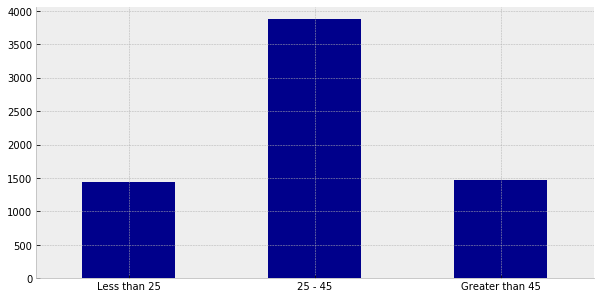

In [8]:
# Graficamos:
fig, ax = create_groupcount_barplot(df, "age_cat", (10, 5), color = "DarkBlue", rot = 0)

#### Sexo

In [9]:
# 
sex_cs = ["Female", "Male"]

df["sex"] = pd.Categorical(df["sex"], categories = sex_cs, ordered = True)
#df.head()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b269690>)

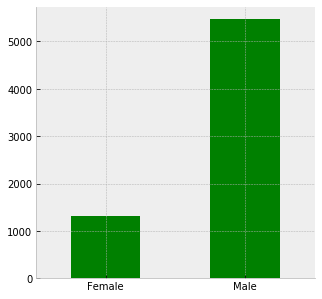

In [10]:
# Gráfica
create_groupcount_barplot(df, "sex", (5, 5), color="green", rot=0)

#### Etnia

In [11]:
#
race_cs = ["African-American", "Caucasian", "Hispanic"]

df["race"] = pd.Categorical(df["race"], categories=race_cs, ordered=True)
#df.head()

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b387d50>)

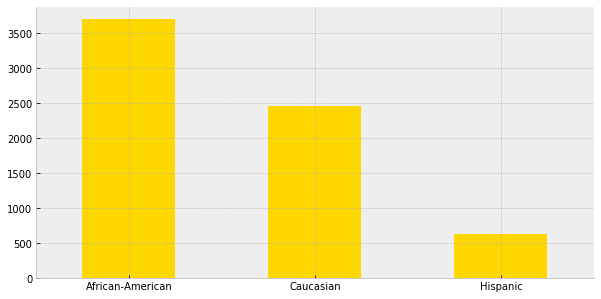

In [12]:
# Gráfica:
create_groupcount_barplot(df, "race", (10, 5), color="gold", rot=0)

##### Observando las gráficas identificamos que  la muestra dee población que estamos analizando se encuentra mayoritariamente entre 25-45 años, son hombres y afroamericanos o caucásicos.

### Reincidencia
Ahora analizamos  reincidencia entre los grupos.

In [13]:
#
recid = df.groupby(["age_cat", "sex", "race"])["two_year_recid"].mean().unstack(level = "race")
recid

race                    African-American  Caucasian  Hispanic
age_cat         sex                                          
Less than 25    Female          0.449704   0.310345  0.411765
                Male            0.645806   0.541254  0.536364
25 - 45         Female          0.382278   0.423948  0.333333
                Male            0.533074   0.433699  0.375000
Greater than 45 Female          0.227273   0.239766  0.217391
                Male            0.425101   0.289157  0.216667

#### De la información que proporciona la tabla podemos identificar que los más jóvenes tienen tasas de reincidencia más altas que personas de mayor edad, excepto entre las mujeres caucásicas.

Además, los hombres afroamericanos tienen un riesgo particularmente alto de reincidencia incluso a medida que envejecen.

**Puntajes de riesgo** A cada individuo en el conjunto de datos se le asignó un decile_score que varía de 1 a 10

Este puntaje representa el riesgo percibido de reincidencia, siendo 1 el riesgo más bajo y 10 el más alto.

A continuación mostramos una gráfica de barras de todos los puntajes por decil.

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b3ca350>)

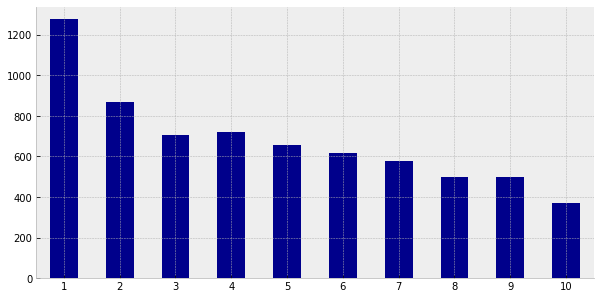

In [14]:
create_groupcount_barplot(df, "decile_score", (10, 5), color="DarkBlue", rot=0)

### ¿Cómo difieren estos puntajes por grupo racial?

Text(0.5, 0.98, 'Frecuencia de score por grupo racial')

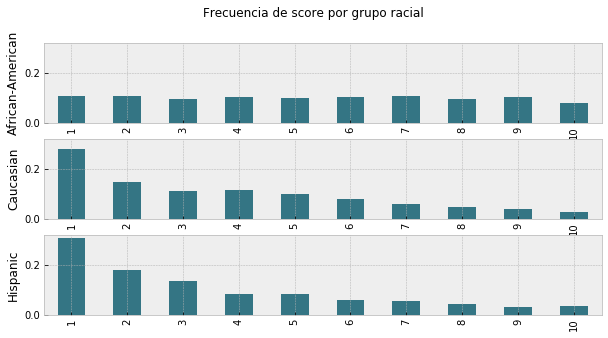

In [15]:
dfgb = df.groupby("race")
race_count = df.groupby("race")["name"].count()

fig, ax = plt.subplots(3, figsize=(10, 5))

for (i, race) in enumerate(["African-American", "Caucasian", "Hispanic"]):
    (
        (dfgb
            .get_group(race)
            .groupby("decile_score")["name"].count() / race_count[race]
        )
        .plot(kind="bar", ax=ax[i], color="#347584")
    )
    ax[i].set_ylabel(race)
    ax[i].set_xlabel("")
    # set equal y limit for visual comparison
    ax[i].set_ylim(0, 0.32)

fig.suptitle("Frecuencia de score por grupo racial")

Mientras que los caucásicos y los hispanos ven la mayoría de su distribución de puntajes en valores bajos, los afroamericanos tienen casi la misma probabilidad de recibir cualquier puntaje

### Puntajes de riesgo y reincidencia

Ahora podemos explorar la relación entre la puntuación de riesgo y la reincidencia real de dos años.

La primera medida que observamos es la frecuencia de reincidencia por decil de puntaje : estos números nos dicen qué porcentaje de personas asignadas a un puntaje de riesgo particular cometieron un nuevo delito dentro de los dos años posteriores a su liberación.

In [16]:
df.groupby("decile_score")["two_year_recid"].mean()

decile_score
1     0.220392
2     0.309112
3     0.375887
4     0.426593
5     0.478723
6     0.564228
7     0.590988
8     0.681363
9     0.698795
10    0.770889
Name: two_year_recid, dtype: float64

Veamos también la correlación entre deciles de score y reincidencia.

In [17]:
df[["decile_score", "two_year_recid"]].corr()

,decile_score,two_year_recid
decile_score,1.000000,0.346797
two_year_recid,0.346797,1.000000


<ul> 
<li> El porcentaje de personas que cometen un nuevo delito  aumenta con la puntuación de riesgo y hay una correlación positiva (~ 0.35)</li>

<li>Esta es una buena noticia: significa que el puntaje está produciendo al menos alguna señal sobre el riesgo de reincidencia de un individuo</li>
<li>Sin embargo, una de las críticas clave de Pro Publica fue que las inexactitudes no eran uniformes, es decir, la herramienta estaba sistemáticamente equivocada con respecto a ciertas poblaciones.</li>
</ul>
Ahora separemos las correlaciones por grupo racial y veamos qué sucede

In [18]:
recid_rates = df.pivot_table(index="decile_score", columns="race", values="two_year_recid")
recid_rates

race,African-American,Caucasian,Hispanic
decile_score,,,
1,0.228643,0.208517,0.244898
2,0.302799,0.313019,0.318584
3,0.419075,0.340659,0.313953
4,0.459740,0.396491,0.346154
5,0.482192,0.460581,0.538462
6,0.559896,0.572165,0.567568
7,0.592500,0.615385,0.470588
8,0.682451,0.719298,0.500000
9,0.707895,0.693878,0.550000


O, en forma gráfica,

Text(0.5, 0.98, 'Tasa de reincidencia por grupo racial')

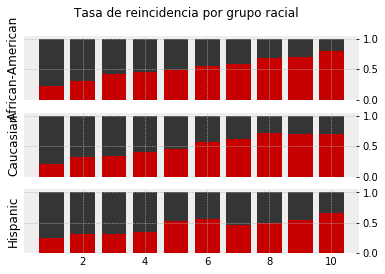

In [19]:

fig, ax = plt.subplots(3, sharex="all")

for (i, _race) in enumerate(["African-American", "Caucasian", "Hispanic"]):
    _rr_vals = recid_rates[_race].values

    ax[i].bar(np.arange(1, 11), _rr_vals, color="#c60000")
    ax[i].bar(np.arange(1, 11), 1 - _rr_vals, bottom=_rr_vals, color="#353535")
    ax[i].set_ylabel(_race)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].yaxis.tick_right()
    ax[i].xaxis.set_ticks_position("none")

fig.suptitle("Tasa de reincidencia por grupo racial")

### Regresión

A continuación, haremos algo ligeramente diferente de lo que se hizo en el artículo de Pro Publica.

**Primero**, exploraremos qué sucede cuando intentamos predecir los puntajes de riesgo de COMPAS utilizando los datos observables que tenemos

**En segundo lugar**, utilizaremos modelos de probabilidad binaria para tratar de predecir si un individuo está en riesgo de reincidencia. Primero haremos esto usando los puntajes de riesgo de COMPAS, y luego intentaremos escribir nuestro propio modelo basado en observaciones de edad, grupo racial y sexo.

### Preprocesamiento

* Nos gustaría utilizar algunas características que son inherentemente no numéricas, como el sexo, el grupo de edad y el grupo racial en nuestro modelo,antes de que podamos hacer eso, necesitamos codificar estos valores (cadenas de texto) como valores numéricos para que nuestros algoritmos de aprendizaje automático puedan entenderlos. 

* La biblioteca sklearn puede hacer esto automáticamente por nosotros con el comando "OneHotEncoder".

* La idea principal de cómo funciona este comando es que se crea  una columna para cada valor posible de una variable categórica, luego estableceremos solo una de estas columnas igual a 1 si la observación tiene la categoría de esa columna, y  todas las demás columnas tomarán el valor 0.

Hagamos un ejemplo

Imagina que tenemos la matriz a continuación

In [20]:
sex = np.array([["Male"], ["Female"], ["Male"], ["Male"], ["Female"]])
sex

array([['Male'],
       ['Female'],
       ['Male'],
       ['Male'],
       ['Female']], dtype='<U6')

La forma de codificar esto sería crear la matriz a continuación

In [21]:
#
sex_encoded = np.array([
    [0.0, 1.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 1.0],
    [1.0, 0.0]
])

sex_encoded

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

Utilizando sklearn :

In [22]:
ohe = preprocessing.OneHotEncoder(sparse = False)
sex_ohe = ohe.fit_transform(sex)
sex_ohe

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [23]:
sex_ohe - sex_encoded

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

### Prediciendo puntajes COMPAS
<ul>
<li>Primero procedemos creando las entradas X e Y en un formato manejable.</li>

<li>Codificamos las variables categóricas usando el OneHotEncoder descrito anteriormente, y luego lo combinamos con los datos no categóricos.</li>

<li>Finalmente, dividimos los datos en subconjuntos de capacitación y validación (prueba)</li>
</ul>

In [24]:
def prep_data(df, continuous_variables, categories, y_var, test_size = 0.15):

    ohe = preprocessing.OneHotEncoder(sparse = False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state = 42
    )

    return X_train, X_test, y_train, y_test

A medida que avanzamos, nuestro objetivo será ver qué variables son más importantes para predecir los puntajes de COMPAS.
Una de nuestras métricas para el éxito será el error absoluto medio (MAE)

In [25]:
def fit_and_report_maes(mod, X_train, X_test, y_train, y_test, y_transform = None, y_inv_transform = None):
    if y_transform is not None:
        mod.fit(X_train, y_transform(y_train))
    else:
        mod.fit(X_train, y_train)

    yhat_train = mod.predict(X_train)
    yhat_test = mod.predict(X_test)

    if y_transform is not None:
        yhat_train = y_inv_transform(yhat_train)
        yhat_test = y_inv_transform(yhat_test)

    return dict(
        mae_train = metrics.mean_absolute_error(y_train, yhat_train),
        mae_test = metrics.mean_absolute_error(y_test, yhat_test)
    )

Comencemos con un modelo lineal simple que utiliza la variable arrestos anteriores

In [26]:
#
X_train, X_test, y_train, y_test = prep_data(df, ["priors_count"], [], "decile_score")

#
fit_and_report_maes(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mae_train': 2.162527833108664, 'mae_test': 2.191754484529134}

- Este modelo simple obtiene un MAE de aproximadamente 2 tanto para los datos de prueba como para los datos de entrenamiento. Esto significa, en promedio, que nuestro modelo puede predecir el puntaje COMPAS (que oscila entre 1 y 10) con un rango de aproximadamento 2 puntos.**

- Si bien el MAE es aproximadamente 2, a menudo es útil saber cómo son los errores en nuestro modelo de predicción. A continuación, creamos un histograma que muestra la distribución de estos errores: en nuestro caso, tomamos la diferencia entre el valor predicho y el valor real, por lo que un valor positivo significa que hemos predicho "en exceso" el puntaje COMPAS y un valor negativo significa que lo hemos subestimado.

Text(0.5, 1.0, 'Test Data')

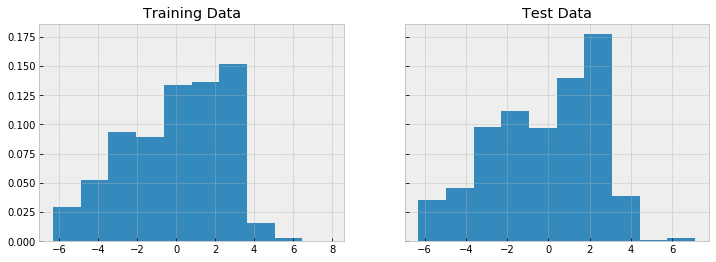

In [27]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

yhat_train = lr_model.predict(X_train)
yhat_test = lr_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey="all")

ax[0].hist(yhat_train - y_train, density=True)
ax[0].set_title("Training Data")
ax[1].hist(yhat_test - y_test, density=True)
ax[1].set_title("Test Data")

- En ambos casos, hay una larga cola de errores que sugiere la existencia de características relevantes que mejorarían nuestro modelo.

- Lo primero que podríamos considerar investigar es si hay no-linealidades en la relación entre el número de arrestos anteriores y el puntaje COMPAS

Intentemos utilizar características polinómicas en nuestras variables exógenas

In [28]:
X_train, X_test, y_train, y_test = prep_data(df, ["priors_count"], [], "decile_score")

# Transform data to quadratic
pf = preprocessing.PolynomialFeatures(2, include_bias=False)
X_train = pf.fit_transform(X_train)
X_test = pf.fit_transform(X_test)

fit_and_report_maes(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mae_train': 2.120405801755292, 'mae_test': 2.1179838134597335}

No vemos un aumento muy significativo en el rendimiento, por lo que también intentamos usar el registro en las variables endógenas

In [30]:
X_train, X_test, y_train, y_test = prep_data(df, ["priors_count"], [], "decile_score")

fit_and_report_maes(
    linear_model.LinearRegression(), X_train, X_test, y_train, y_test,
    y_transform=np.log, y_inv_transform=np.exp)

{'mae_train': 2.2550821558610115, 'mae_test': 2.3332184125647917}

Todavía no hay mejora ... El siguiente paso natural es agregar más funciones a nuestra regresión

In [31]:

X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], ["age_cat", "race", "sex"], "decile_score")

fit_and_report_maes(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mae_train': 1.8076563650603423, 'mae_test': 1.827701017349789}

#### Al permitir variables  de edad, grupo racial y sexo, podemos mejorar ligeramente el MAE. Los errores también parecen tener una cola menos extrema

Text(0.5, 1.0, 'Test Data')

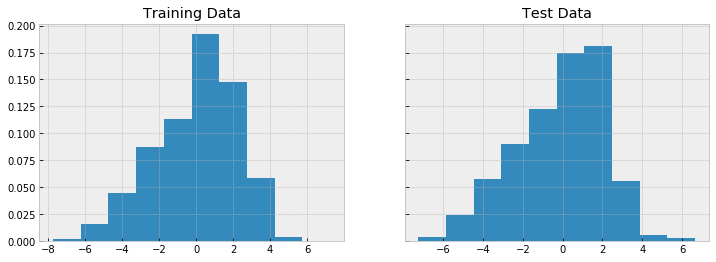

In [32]:

X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], ["age_cat", "race", "sex"], "decile_score")

lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

yhat_train = lr_model.predict(X_train)
yhat_test = lr_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey="all")

ax[0].hist(yhat_train - y_train, density=True)
ax[0].set_title("Training Data")
ax[1].hist(yhat_test - y_test, density=True)
ax[1].set_title("Test Data")

Los coeficientes se enumeran a continuación:

In [33]:
names = ["priors_count", "Less than 25", "25-45", "Greater than 45", "African-American",
    "Caucasian", "Hispanic", "Female", "Male"
]
for (_name, _coef) in zip(names, lr_model.coef_):
    print(_name, ": ", _coef)

priors_count :  0.27999230496845806
Less than 25 :  -0.1026275580794646
25-45 :  -1.718901894818139
Greater than 45 :  1.8215294528976027
African-American :  0.6102522379830784
Caucasian :  -0.10156939689442336
Hispanic :  -0.5086828410886545
Female :  0.042935824274662304
Male :  -0.04293582427466225


### ¿Qué se destaca en estos coeficientes?

** ¿Puede desarrollar un modelo que funcione mejor para imitar los puntajes de riesgo?

### Modelos de probabilidad binaria
- Los modelos de probabilidad binaria se utilizan para modelar resultados de "todo o nada", por ejemplo, la ocurrencia de un evento determinado.  
- Con esta probabilidad en la mano, el investigador elige un límite aceptable (quizás 0.5) por encima del cual se predice que ocurrirá el evento.

- Nota

<blockquote>Los modelos de probabilidad binaria pueden considerarse como un caso especial de clasificación.

En la clasificación, se nos da un conjunto de características y se nos pide predecir un número finito de etiquetas discretas. 

En nuestro ejemplo, nos interesará saber cómo funcionan los puntajes de COMPAS para predecir la reincidencia y cómo su capacidad de predecir depende del grupo racial o género.

Para ayudarnos a evaluar el rendimiento de varios modelos, utilizaremos una nueva métrica llamada **matriz de confusión.** Scikit-learn calcula  esta métrica y también proporciona una buena descripción de lo que se calcula. </blockquote>

In [34]:
help(metrics.confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics.classification:

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
    Compute confusion matrix to evaluate the accuracy of a classification
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` but
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.
    
    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.
    
    labels : array, shape = [n_classes], optional
        List of labels to index the m

In [35]:
def report_cm(mod, X_train, X_test, y_train, y_test):
     return dict(cm_train=metrics.confusion_matrix(y_train, mod.predict(X_train)),
         cm_test=metrics.confusion_matrix(y_test, mod.predict(X_test)))

Comenzaremos con un modelo de  regresión logística utilizando solo **"decile_score"** como característica y luego examinaremos cómo las matrices de confusión difieren según la raza y el sexo.

In [36]:
from patsy import dmatrices
groups = ["overall", "African-American", "Caucasian", "Hispanic", "Female", "Male"]

ind = [
    "Portion_of_NoRecid_and_LowRisk", "Portion_of_Recid_and_LowRisk",
    "Portion_of_NoRecid_and_HighRisk", "Portion_of_Recid_and_HighRisk"
]

fmla = "two_year_recid ~ C(decile_score)"
y,X = dmatrices(fmla, df)
X_train, X_test, y_train, y_test, df_train, df_test = model_selection.train_test_split(
    X,y.reshape(-1),df, test_size=0.25, random_state=42
)


decile_mod = linear_model.LogisticRegression(solver="lbfgs").fit(X_train,y_train)

def cm_tables(pred, y, df):
    output = pd.DataFrame(index=ind, columns=groups)
    for group in groups:
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
        else:
            subset=np.full(y.shape, True)

        y_sub = y[subset]
        pred_sub = pred[subset]

        cm = metrics.confusion_matrix(y_sub, pred_sub)

        # Compute fraction for which the guess is correct
        total = cm.sum()
        vals = np.array(cm/total)
        output.loc[:, group] = vals.reshape(-1)


    def cond_probs(col, axis):
        d=int(np.sqrt(len(col)))
        pcm = np.array(col).reshape(d,d)
        pcm = pcm/pcm.sum(axis=axis, keepdims=True)
        return(pcm.reshape(-1))

    given_outcome = output.copy()
    given_outcome.index = ["P(LowRisk|NoRecid)","P(HighRisk|NoRecid)","P(LowRisk|Recid)","P(HighRisk|Recid)"]
    given_outcome=given_outcome.apply(lambda c: cond_probs(c,1))

    given_pred = output.copy()
    given_pred.index = ["P(NoRecid|LowRisk)","P(NoRecid|HighRisk)","P(Recid|LowRisk)","P(Recid|HighRisk)"]
    given_pred=given_pred.apply(lambda c: cond_probs(c,0))
    return(output,given_outcome, given_pred)

output, given_outcome, given_pred =cm_tables(decile_mod.predict(X_test),
                                             y_test, df_test)
output

,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.361815,0.263270,0.475000,0.522581,0.438040,0.342222
Portion_of_Recid_and_LowRisk,0.191514,0.230361,0.136667,0.167742,0.207493,0.187407
Portion_of_NoRecid_and_HighRisk,0.152033,0.140127,0.168333,0.161290,0.141210,0.154815
Portion_of_Recid_and_HighRisk,0.294638,0.366242,0.220000,0.148387,0.213256,0.315556


- Los resultados del modelo contienen información sobre el porcentaje de verdaderos negativos, falsos negativos, falsos positivos y verdaderos positivos. 

- Las probabilidades conjuntas (de predicción y resultado dado el grupo racial o el sexo) en la tabla anterior son un poco difíciles de interpretar. Las probabilidades condicionales pueden ser más fáciles de pensar. Veamos la probabilidad de resultados dada la predicción y el grupo racial  o el sexo.

In [37]:
given_pred

,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.704128,0.652632,0.738342,0.764151,0.756219,0.688525
P(NoRecid|HighRisk),0.393939,0.386121,0.383178,0.530612,0.493151,0.372607
P(Recid|LowRisk),0.295872,0.347368,0.261658,0.235849,0.243781,0.311475
P(Recid|HighRisk),0.606061,0.613879,0.616822,0.469388,0.506849,0.627393


- Como puede ver, la distribución de resultados condicionada a las predicciones no varía demasiado con el grupo racial. --Además, en todo caso, discrimina a favor de los afroamericanos.

- El algoritmo parece predecir demasiado la reincidencia para las mujeres en comparación con los hombres. Este es un tema importante. Sin embargo, no lo discutiremos demasiado porque (1) veremos a continuación que cuando se ve la equidad de otra manera, se favorece a las mujeres sobre los hombres, y (2) la compañía que produce COMPAS también produce un cuestionario separado y una calificación de riesgo diseñada solo para mujeres.

In [38]:
given_outcome


,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.653887,0.533333,0.776567,0.757009,0.678571,0.646154
P(HighRisk|NoRecid),0.346113,0.466667,0.223433,0.242991,0.321429,0.353846
P(LowRisk|Recid),0.340369,0.276730,0.433476,0.520833,0.398374,0.329134
P(HighRisk|Recid),0.659631,0.723270,0.566524,0.479167,0.601626,0.670866


#### Falsos positivos y negativos
- ¿Qué pasa si volteamos esto y observamos las distribuciones de predicciones condicionadas a los resultados? 
- ¿Por qué mirar estas probabilidades? 
- Una razón es que existe una larga tradición en la aplicación de la  ley en la  que es mucho peor castigar a los inocentes que dejar en libertad a los culpables. Esta idea se remonta al menos a 1760 y a la proporción de Blackstone

<blockquote>"Es mejor que escapen diez personas culpables que la que sufre un inocente". -William Blackstone</blockquote>

La proporción de Blackstone dice que deberíamos estar particularmente preocupados por P (HighRisk | NoRecid). Esta probabilidad también se denomina tasa de falsos positivos.


In [39]:
given_outcome

,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.653887,0.533333,0.776567,0.757009,0.678571,0.646154
P(HighRisk|NoRecid),0.346113,0.466667,0.223433,0.242991,0.321429,0.353846
P(LowRisk|Recid),0.340369,0.276730,0.433476,0.520833,0.398374,0.329134
P(HighRisk|Recid),0.659631,0.723270,0.566524,0.479167,0.601626,0.670866


- Podemos observar grandes disparidades por grupo racial  en la tasa de falsos positivos (y la tasa de falsos negativos). - - Este es uno de los principales hallazgos del artículo de Pro Publica.

- En respuesta a Pro Publica, Northpointe, la compañía que produce COMPAS, argumentó que COMPAS no está sesgado porque las probabilidades de resultados condicionales a las predicciones (como P (NoRecid | LowRisk)) son aproximadamente iguales en todas las razas. Llamaremos a un algoritmo de predicción con esta propiedad **"bien calibrado"**. Estar bien calibrado es un criterio para la equidad de un algoritmo de predicción.

- La crítica de Pro Publica se centra en un criterio diferente: que la probabilidad de que las categorías pronosticadas dependan de resultados verdaderos debe ser igual en todos los grupos (es decir, P (HighRisk | NoRecid) debe ser igual en todas las razas).Un algoritmo de predicción con esta propiedad se denomina **"balanceado"**.

#### Visualizando Calibración y Balance
Podemos obtener una visión un poco más detallada de la calibración y el balance al reconocer que los algoritmos de predicción generalmente calculan una probabilidad pronosticada, no solo un resultado predicho discreto. El resultado previsto generalmente se asignará a la categoría con la mayor probabilidad prevista. Podemos examinar la calibración gráficamente trazando la P (reincidencia | probabilidad predicha).

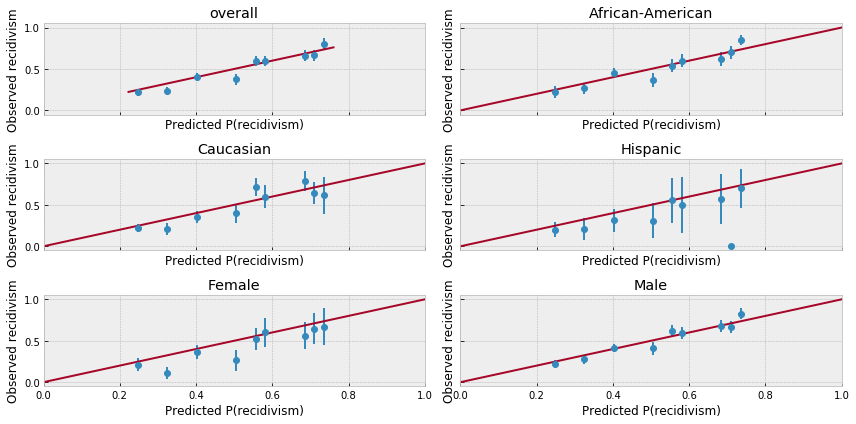

In [40]:
import scipy

def calibration_plot(pred, y, df, bins=20):
    fig,ax = plt.subplots(3,2, figsize=(12,6), sharey=True, sharex=True)
    for (g,group) in enumerate(groups):
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
        else:
            subset=np.full(y.shape,True)
        _ax = ax[np.unravel_index(g, ax.shape)]
        y_sub = y[subset]
        pred_sub = pred[subset]
        mu, edges, n=scipy.stats.binned_statistic(pred_sub,y_sub,'mean',bins=bins)
        se, edges,n=scipy.stats.binned_statistic(pred_sub,y_sub,
                         lambda x: np.std(x)/np.sqrt(len(x)),bins=bins)
        midpts = (edges[0:-1]+edges[1:])/2
        _ax.errorbar(midpts, mu, yerr=1.64*se, fmt='o')
        _ax.set_title(group)
        _ax.set_ylabel("Observed recidivism")
        _ax.set_xlabel("Predicted P(recidivism)")
        x = np.linspace(*_ax.get_xlim())
        _ax.plot(x, x)
        _ax.set_xlim(0.0,1.0)
    fig.tight_layout()
    return(fig,ax)

calibration_plot(decile_mod.predict_proba(X_test)[:,1],
                 df_test["two_year_recid"],
                 df_test);

Esta figura es una forma de visualizar qué tan bien calibradas están estas predicciones. 
Los puntos son promedios agrupados de reincidencia observada condicional a que la reincidencia pronosticada esté en algún rango. 
Las barras de error representan un intervalo de confianza del 90%. 
- Una predicción perfectamente calibrada tendría todos estos puntos a lo largo de la línea de 45 grados. Para los puntos por debajo de la línea de 45 grados, el algoritmo sobrepredice la reincidencia.

##### ¿Qué crees que pasaría si se hiciera el diagrama de calibración usando la muestra de entrenamiento? Verifique 

El algoritmo parece bastante bien calibrado. No parece estar cometiendo errores sistemáticos en una dirección condicional en ninguna raza. Parece haber una sobreprevisión sistemática para las mujeres en comparación con los hombres.

**Ahora, creemos una figura para examinar el equilibrio.**
El equilibrio se trata de la distribución de predicciones condicionadas a los resultados, por lo que trazaremos histogramas de probabilidades predichas condicionales a los resultados realizados

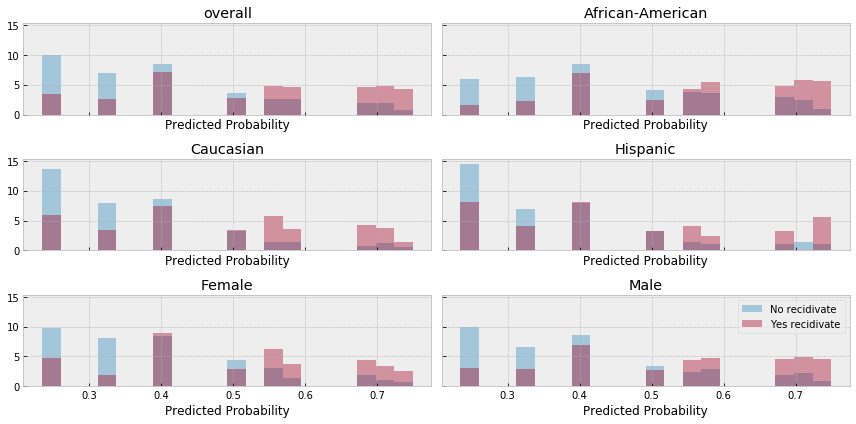

In [41]:
import seaborn as sns
def balance_hist_plot(pred, y, df, bins=20):
    fig,ax = plt.subplots(3,2, figsize=(12,6), sharey=True, sharex=True)
    for (g,group) in enumerate(groups):
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
        else:
            subset=np.full(y.shape,True)
        _ax = ax[np.unravel_index(g, ax.shape)]
        y_sub = y[subset]
        pred_sub = pred[subset]
        sns.distplot(pred_sub[y_sub==0], hist=True, bins=bins, kde=False, ax=_ax,
                     label="No recidivate", norm_hist=True, axlabel="Predicted Probability")
        sns.distplot(pred_sub[y_sub==1], hist=True, bins=bins, kde=False, ax=_ax,
                     label="Yes recidivate", norm_hist=True, axlabel="Predicted Probability")
        _ax.set_title(group)

    plt.legend()
    fig.tight_layout()
    return(fig,ax)

balance_hist_plot(decile_mod.predict_proba(X_test)[:,1],
                  df_test["two_year_recid"],
                  df_test);

- Esta cifra es algo útil, pero no representa un equilibrio especialmente claro, así que intentemos otra cosa.
- Para obtener tasas de falsos positivos y falsos negativos, debemos asignar las probabilidades predichas a los resultados. La opción más común sería predecir la reincidencia si la probabilidad pronosticada es mayor que 0.5. Sin embargo, si queremos ajustar las tasas de falsos positivos y falsos negativos, podríamos elegir otro umbral y predecir la reincidencia si la probabilidad pronosticada excede este umbral. Diferentes umbrales conducirán a diferentes tasas de falsos negativos y falsos positivos, así que grafiquemos estas tasas como funciones del umbral.

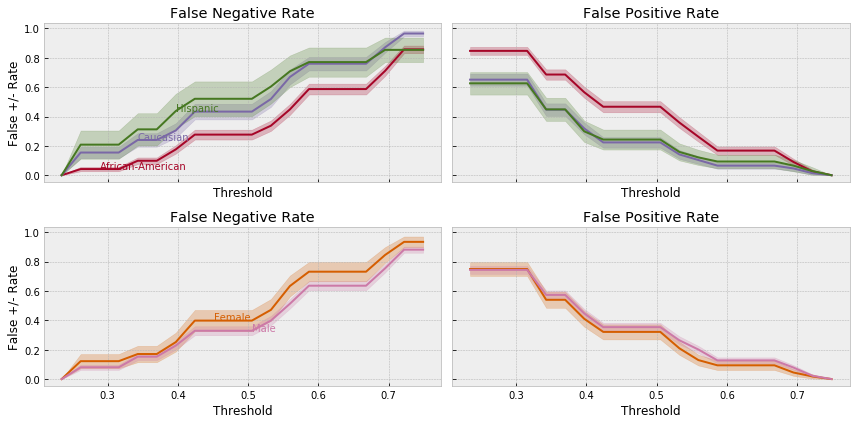

In [42]:

def balance_threshold_plot(pred, y, df, bins=20):
    fig,ax = plt.subplots(2,2, figsize=(12,6), sharey=True,
                          sharex=True)
    x = np.linspace(min(pred), max(pred), bins)
    # get colors defined by theme
    colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for (g, group) in enumerate(groups):
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
            r = 0
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
            r = 1
        else:
            continue
        y_sub = y[subset]
        pred_sub = pred[subset]
        _ax = ax[r,0]
        fn = np.array([np.mean(pred_sub[y_sub==1]<xi) for xi in x])
        c1 = sum(y_sub==1)
        sen = np.sqrt(fn*(1-fn)/c1)
        fp = np.array([np.mean(pred_sub[y_sub==0]>xi) for xi in x])
        c0 = sum(y_sub==0)
        sep = np.sqrt(fp*(1-fp)/c0)
        p=_ax.plot(x, fn, color=colors[g])
        _ax.fill_between(x, fn-1.64*sen, fn+1.64*sen, alpha=0.25, color=colors[g])
        _ax.annotate(group, (x[bins//7*g], fn[bins//7*g]), color=colors[g])
        _ax.set_ylabel("False +/- Rate")
        _ax.set_xlabel("Threshold")
        _ax.set_title("False Negative Rate")

        _ax = ax[r,1]
        p=_ax.plot(x, fp, color=colors[g])
        _ax.fill_between(x, fp-1.64*sep, fp+1.64*sep, alpha=0.25, color=colors[g])
        _ax.set_xlabel("Threshold")
        _ax.set_title("False Positive Rate")

    fig.tight_layout()
    return(fig,ax)

balance_threshold_plot(decile_mod.predict_proba(X_test)[:,1],
                       df_test["two_year_recid"],
                       df_test);


A partir de esto, podemos ver más fácilmente el problema del equilibrio: independientemente del umbral que elijamos, los afroamericanos tendrán una tasa de falsos positivos más alta que los caucásicos.

Hemos visto que los puntajes de COMPAS están bien calibrados, condicionados a la raza, pero no equilibrados. ¿Podemos crear una predicción alternativa que esté bien calibrada y equilibrada?

**Crear una predicción alternativa**

Como ejercicio inicial, pronostiquemos la reincidencia utilizando las variables en este conjunto de datos que no sean el grupo racial  y el puntaje COMPAS.
Casi todas las variables en estos datos son categóricas. Cualquier función de variables categóricas puede representarse como una función lineal de variables  y sus interacciones. Dado que la linealidad en los indicadores no impone ninguna restricción sustancial aquí, un modelo lineal penalizado como  Lasso parece una buena opción para la predicción. 
Para mantener el tiempo de cálculo razonable, no incluimos todos los términos de interacción e indicador aquí. Para garantizar que las probabilidades predichas estén entre 0 y 1, ajustamos una regresión logística con una penalización de $ \ e-1 $.

In [43]:

from sklearn import model_selection, linear_model
from patsy import dmatrices

# charge_desc has many values with one observations, we will
# combine these descriptions into a single "other." This could
# be improved upon by looking at the text of descriptions and
# combining.
df.c_charge_desc = df.c_charge_desc.fillna("")
df["charge_cat"] = df.c_charge_desc
cnt = df.c_charge_desc.value_counts()[df.c_charge_desc]
cnt.index = df.index
df.loc[cnt<10,"charge_cat"] = "other"
df.charge_cat = df.charge_cat.astype('category')
df.sex = df.sex.astype('category')


fmla = "two_year_recid ~ sex*(age + juv_fel_count + juv_misd_count + juv_other_count + C(priors_count) + c_charge_degree + charge_cat)"

y,X = dmatrices(fmla, df)
print("There are {} features".format(X.shape[1]))
X_train, X_test, y_train, y_test, df_train, df_test = model_selection.train_test_split(
    X,pd.Series(y.reshape(-1),index=df.index),df, test_size=0.25, random_state=42
)

lasso_mod=linear_model.LogisticRegressionCV(cv=5,verbose=True,
                                            Cs=10, penalty='l1',
                                            max_iter=100,
                                            scoring="neg_log_loss",
                                            solver="liblinear").fit(X_train, y_train)

There are 260 features
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s finished


Veamos el parámetro de regularización elegido y los coeficientes distintos de cero.

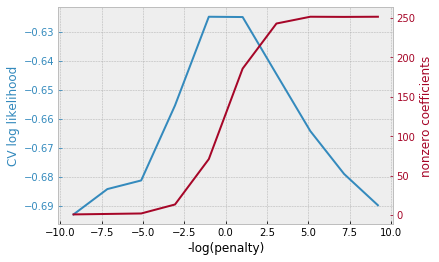

In [44]:
# plots illustrating regularization parameter choice
scores=lasso_mod.scores_[1.0].mean(axis=0)
logpenalties=np.log(lasso_mod.Cs_)
nnonzero=(np.abs(lasso_mod.coefs_paths_[1.0])>1e-6).sum(axis=2).mean(axis=0)
colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax1 = plt.subplots()
ax1.plot(logpenalties,scores, color=colors[0])
ax1.set_ylabel("CV log likelihood", color=colors[0])
ax1.set_xlabel("-log(penalty)")
ax1.tick_params('y', colors=colors[0])
ax2 = ax1.twinx()
ax2.plot(logpenalties,nnonzero, color=colors[1])
ax2.set_ylabel("nonzero coefficients", color=colors[1])
ax2.tick_params('y', colors=colors[1])
ax2.grid(b=None);

Veamos también los coeficientes distintos de cero. Debemos tener cuidado al interpretarlos, ya que se necesitan suposiciones relativamente fuertes para que Lasso produzca estimaciones de coeficientes consistentes. (Lasso ofrece predicciones precisas bajo supuestos más débiles que los necesarios para estimaciones de coeficientes consistentes).

In [45]:
# table of nonzero coefficients
coef = pd.DataFrame(index = X.design_info.column_names, columns=["Value"])
coef.Value = np.transpose(lasso_mod.coef_)
print(sum(np.abs(coef.Value)>1.0e-8))
with pd.option_context('display.max_rows', None):
    display(coef[np.abs(coef.Value)>1.0e-8])

82


,Value
Intercept,0.021389
sex[T.Male],0.724759
C(priors_count)[T.2],0.325197
C(priors_count)[T.3],0.612273
C(priors_count)[T.4],0.749697
C(priors_count)[T.5],0.732783
C(priors_count)[T.6],0.792315
C(priors_count)[T.7],1.032682
C(priors_count)[T.8],1.322565
C(priors_count)[T.9],1.286943


Ahora, veamos la calibración y el equilibrio usando tablas y figuras similares a las que hicimos anteriormente.

,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.412493,0.333333,0.490000,0.593548,0.599424,0.364444
Portion_of_Recid_and_LowRisk,0.140837,0.160297,0.121667,0.096774,0.046110,0.165185
Portion_of_NoRecid_and_HighRisk,0.190925,0.182590,0.201667,0.200000,0.250720,0.175556
Portion_of_Recid_and_HighRisk,0.255745,0.323779,0.186667,0.109677,0.103746,0.294815


,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.683594,0.646091,0.708434,0.747967,0.705085,0.674897
P(NoRecid|HighRisk),0.355126,0.331140,0.394595,0.468750,0.307692,0.359098
P(Recid|LowRisk),0.316406,0.353909,0.291566,0.252033,0.294915,0.325103
P(Recid|HighRisk),0.644874,0.668860,0.605405,0.531250,0.692308,0.640902


,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.745474,0.675269,0.801090,0.859813,0.928571,0.688112
P(HighRisk|NoRecid),0.254526,0.324731,0.198910,0.140187,0.071429,0.311888
P(LowRisk|Recid),0.427441,0.360587,0.519313,0.645833,0.707317,0.373228
P(HighRisk|Recid),0.572559,0.639413,0.480687,0.354167,0.292683,0.626772


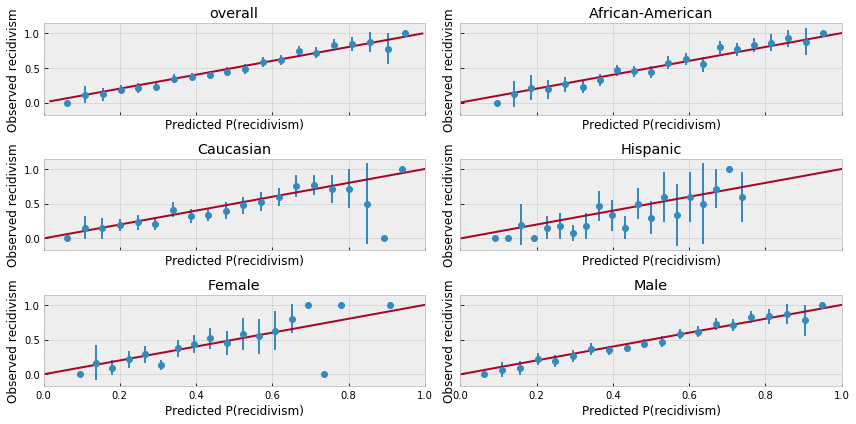

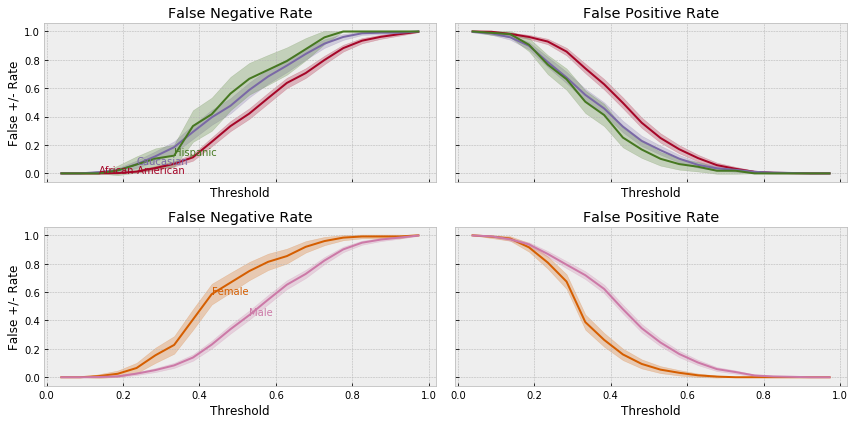

In [46]:
output, given_outcome, given_pred =cm_tables(
    lasso_mod.predict(X_test),
    y_test,
    df_test
)
display(output)
display(given_pred)
display(given_outcome)

calibration_plot(lasso_mod.predict_proba(X_test)[:,1],y_test, df_test)
balance_threshold_plot(lasso_mod.predict_proba(X_test)[:,1],y_test, df_test);

Al igual que con el puntaje COMPAS, nuestras predicciones están bien calibradas, pero las tasas de falsos negativos y falsos positivos no están bien equilibradas entre los grupos raciales.

### TAREA: Intente mejorar el equilibrio y / o la calibración creando una predicción alternativa.

#### Regularizando para maximizar el equilibrio
Intentar mejorar el equilibrio mediante modificaciones ad-hoc será difícil. Tratemos de hacerlo de manera más sistemática. Por lo general, seleccionamos modelos y elegimos regularizatoin para minimizar los errores de predicción. También podemos seleccionar modelos y parámetros de regularización para optimizar algunos otros criterios. Elija el parámetro de regularización para lazo para maximizar el equilibrio.

In [46]:
# define a custom CV criteria to maximize
def balance_scorer(y_true, prob, df, weights):
    ind = df.isin(y_true.index)
    df_cv = df.loc[y_true.index.values,:]
    b = df_cv.race=="African-American"
    w = df_cv.race=="Caucasian"
    y_pred = 1*(prob>0.5)
    fprb = np.mean(y_pred[(y_true==0) & b])
    fprw = np.mean(y_pred[(y_true==0) & w])
    fnrb = np.mean(y_pred[(y_true==1) & b]==0)
    fnrw = np.mean(y_pred[(y_true==1) & w]==0)
    return(-weights[0]*(fprb-fprw)**2 +
           -weights[1]*(fnrb-fnrw)**2 +
           -weights[2]*(metrics.log_loss(y_true, prob, normalize=True)))

score_params = {"df": df_train, "weights": [10.0, 1.0, 0.0]}
scorer = metrics.make_scorer(balance_scorer, **score_params, needs_proba=True)
grid_cv = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(penalty="l1",
                                              max_iter=100,
                                              solver="liblinear"),
    scoring=scorer,
    cv=5,
    param_grid={'C':
    np.exp(np.linspace(-10,10,10))},
    return_train_score=True,
    verbose=True,
    refit=True,
    iid=True)

balance_mod=grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.7s finished


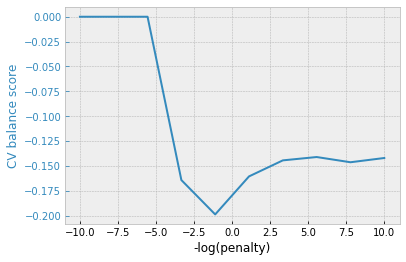

In [47]:
# plots illustrating regularization parameter choice
def grid_cv_plot(mod, ylabel=""):
    scores=mod.cv_results_["mean_test_score"]
    Cdict=mod.cv_results_["params"]
    logpenalties=np.log([d['C'] for d in Cdict])
    colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax1 = plt.subplots()
    ax1.plot(logpenalties,scores, color=colors[0])
    ax1.set_ylabel(ylabel, color=colors[0])
    ax1.set_xlabel("-log(penalty)")
    ax1.tick_params('y', colors=colors[0]);
grid_cv_plot(balance_mod,"CV balance score")


Podemos equilibrar perfectamente haciendo que el parámetro de regularización sea muy grande. Desafortunadamente, esto hace que todas las predicciones sean idénticas, por lo que estas predicciones no son tan útiles.

In [48]:
output, given_outcome, given_pred =cm_tables(
    balance_mod.best_estimator_.predict(X_test),
    y_test,
    df_test
)
display(output)
display(given_pred)
display(given_outcome)

/Applications/anaconda/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.553329,0.493631,0.611667,0.690323,0.645533,0.52963
Portion_of_Recid_and_LowRisk,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Portion_of_NoRecid_and_HighRisk,0.446671,0.506369,0.388333,0.309677,0.354467,0.47037
Portion_of_Recid_and_HighRisk,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.553329,0.493631,0.611667,0.690323,0.645533,0.52963
P(NoRecid|HighRisk),NaN,NaN,NaN,NaN,NaN,NaN
P(Recid|LowRisk),0.446671,0.506369,0.388333,0.309677,0.354467,0.47037
P(Recid|HighRisk),NaN,NaN,NaN,NaN,NaN,NaN


,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),1.0,1.0,1.0,1.0,1.0,1.0
P(HighRisk|NoRecid),0.0,0.0,0.0,0.0,0.0,0.0
P(LowRisk|Recid),1.0,1.0,1.0,1.0,1.0,1.0
P(HighRisk|Recid),0.0,0.0,0.0,0.0,0.0,0.0


¿Qué sucede si cambiamos nuestra función de puntuación de CV para preocuparnos tanto por la predicción como por el equilibrio?


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.9s finished


,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.404243,0.325902,0.483333,0.574194,0.556196,0.365185
Portion_of_Recid_and_LowRisk,0.149087,0.167728,0.128333,0.116129,0.089337,0.164444
Portion_of_NoRecid_and_HighRisk,0.190336,0.181529,0.201667,0.200000,0.242075,0.177037
Portion_of_Recid_and_HighRisk,0.256335,0.324841,0.186667,0.109677,0.112392,0.293333


,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.679881,0.642259,0.705596,0.741667,0.696751,0.673497
P(NoRecid|HighRisk),0.367733,0.340517,0.407407,0.514286,0.442857,0.359223
P(Recid|LowRisk),0.320119,0.357741,0.294404,0.258333,0.303249,0.326503
P(Recid|HighRisk),0.632267,0.659483,0.592593,0.485714,0.557143,0.640777


,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.730564,0.660215,0.790191,0.831776,0.861607,0.689510
P(HighRisk|NoRecid),0.269436,0.339785,0.209809,0.168224,0.138393,0.310490
P(LowRisk|Recid),0.426121,0.358491,0.519313,0.645833,0.682927,0.376378
P(HighRisk|Recid),0.573879,0.641509,0.480687,0.354167,0.317073,0.623622


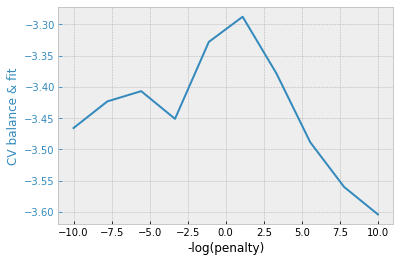

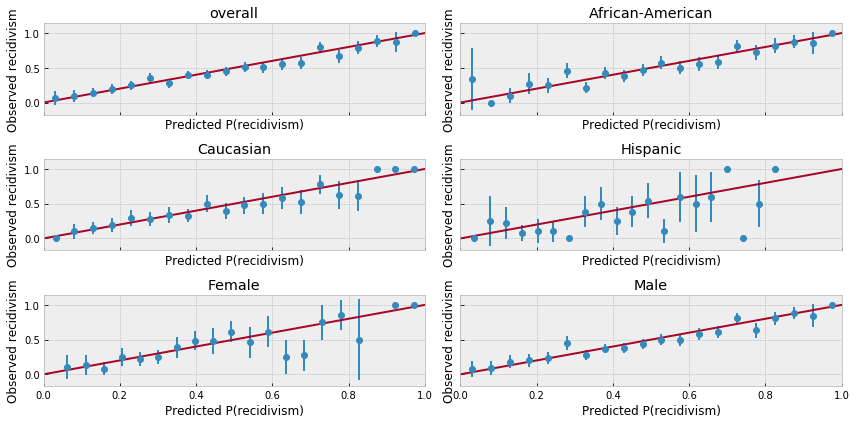

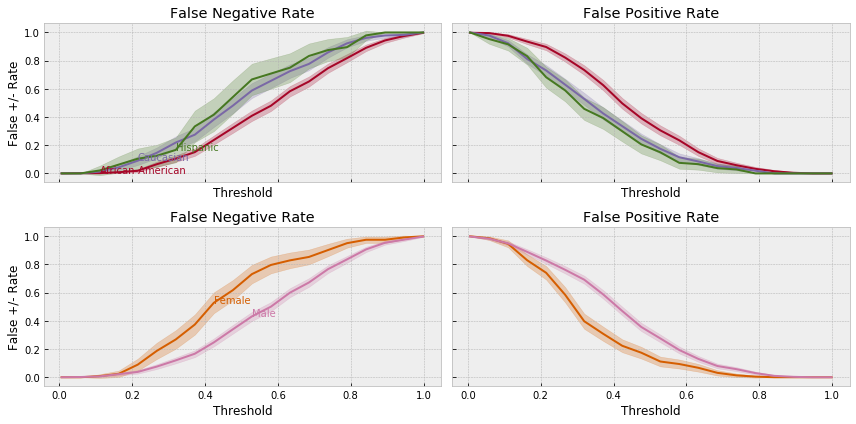

In [49]:
score_params = {"df": df_train, "weights": [10.0, 1.0, 5.0]}
grid_cv.set_params(scoring=metrics.make_scorer(balance_scorer, **score_params, needs_proba=True))
bf_mod=grid_cv.fit(X_train,y_train)
grid_cv_plot(bf_mod,"CV balance & fit")

output, given_outcome, given_pred =cm_tables(
    bf_mod.best_estimator_.predict(X_test),
    y_test,
    df_test
)
display(output)
display(given_pred)
display(given_outcome)
calibration_plot(bf_mod.best_estimator_.predict_proba(X_test)[:,1],y_test, df_test)
balance_threshold_plot(bf_mod.best_estimator_.predict_proba(X_test)[:,1],y_test, df_test);

#### TAREA ** Modifique la función de puntuación de validación cruzada para ver cómo afecta la calibración y el equilibrio.

### Las compensaciones son inevitables
Podríamos intentar ajustar nuestras predicciones aún más para mejorar el equilibrio. Sin embargo, motivado en parte por este ejemplo de COMPAS,se demostró que es imposible que cualquier algoritmo de predicción esté perfectamente equilibrado y bien calibrado. Las mejoras en el equilibrio necesariamente empeoran la calibración.

#### Referencias bibliográficas
[DMB16] William Dieterich, Christina Mendoza, and Tim Brennan. Compas risk scales: demonstrating accuracy equity and predictive parity. Technical Report, Northpoint Inc, 2016. URL: http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf.

[KMR17] Jon Kleinberg, Sendhil Mullainathan, and Manish Raghavan. Inherent trade-offs in the fair determination of risk scores. In 8th Innovations in Theoretical Computer Science Conference (ITCS 2017). Schloss Dagstuhl-Leibniz-Zentrum fuer Informatik, 2017. URL: http://drops.dagstuhl.de/opus/volltexte/2017/8156/.